In [376]:
import pandas as pd
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
import json
import glob
import itertools

from collections import defaultdict

EXPERIMENTS = ["strong_scaling", "weak_scaling", "duplicate_keys"]
# EXPERIMENTS = ["strong_scaling", "weak_scaling"]
EXP_TYPES = ["build", "intersect"]
# MODES = ["noindex_nomanaged", "index_nomanaged", "noindex_managed", "index_managed"]
# MODES = ["noindex_managed", "index_managed"]
MODES = ["rand", "seq"]

SYSTEMS = ["dgx2", "summit"]
# HASH_FUNCS = ["id", "murmur"]
HASH_FUNCS = ["murmur"]
COMPONENTS = dict()
COMPONENTS["build"] = ["countBinSizes", "countKeyBuff", "populateKeyBuffs", "countFinalKeys", "allToAll", "building", "total"]

GROUPS = dict()
GROUPS["build"] = ["phase1", "phase2", "phase3", "phase4", "misc"]

# data[EXPERIMENT][EXP_TYPE][MODE]
results = dict()
results_prof = dict()

%matplotlib inline
from six import iteritems
from matplotlib.lines import Line2D

fmarkers=Line2D.filled_markers

plt.style.use('ggplot')

print(EXPERIMENTS)
print(EXP_TYPES)
print(MODES)

for sys in SYSTEMS:
    results[sys] = dict()
    results_prof[sys] = dict()
    for hash_func in HASH_FUNCS:
        results[sys][hash_func] = dict()
        results_prof[sys][hash_func] = dict()
        for exp in EXPERIMENTS:
            results[sys][hash_func][exp] = dict()
            results_prof[sys][hash_func][exp] = dict()
            for exp_type in EXP_TYPES:
                results[sys][hash_func][exp][exp_type] = dict()
                results_prof[sys][hash_func][exp][exp_type] = dict()
                for mode in MODES:
                    results[sys][hash_func][exp][exp_type][mode] = defaultdict(list)
                    results_prof[sys][hash_func][exp][exp_type][mode] = dict()
                    # strong_scaling keycount --> tuples of (gpucount, time)
                    # weak_scaling keycount / dev --> tuples of (gpucount, time)
                    # duplicate_keys keycount --> tuples of (tablesize, time)


['strong_scaling', 'weak_scaling', 'duplicate_keys']
['build', 'intersect']
['rand', 'seq']


In [379]:
def loadStrongScaling(system, hash_func):
    exp = "strong_scaling"
    for exp_type in EXP_TYPES:
        for mode in MODES:
            file_name = "./" + system + "/" + exp + "/results/" + exp_type + "/" + exp + "_" + mode + "_" + hash_func + ".txt"
            with open(file_name, "r") as data:
                keycount = -1
                gpucount = -1
                for line in data:
                    if exp in line or "keycount" in line or "tests" in line or "total" in line:
                        continue
                    
                    if "times:" in line:
                        line_info = line.strip("\n").split()
                        time = float(line_info[1])
                        if system == "summit" and keycount == 2**30:
                            print(f"keycount: {keycount} exp_type: {exp_type} mode: {mode} gpucount: {gpucount} time: {time}")
                            print(f"filename: {file_name}")
                        results[system][hash_func][exp][exp_type][mode][keycount].append((gpucount, time))
                    else:
                        line_info = line.strip("\n").split(",")

                        keycount = int(line_info[0])
                        gpucount = int(line_info[1])
                
        
def loadWeakScaling(system, hash_func):
    exp = "weak_scaling"
    for exp_type in EXP_TYPES:
        for mode in MODES:
            file_name = "./" + system + "/" + exp + "/results/" + exp_type + "/" + exp + "_" + mode + "_" + hash_func + ".txt"
            with open(file_name, "r") as data:
                keycount = -1
                gpucount = -1
                for line in data:
                    if exp in line or "keycount" in line or "tests" in line or "total" in line:
                        continue
                    
                    if "times:" in line:
                        line_info = line.strip("\n").split()
                        time = float(line_info[1])
                        key_per_dev = int(keycount / gpucount)
                        results[system][hash_func][exp][exp_type][mode][key_per_dev].append((gpucount, time))
                    else:
                        line_info = line.strip("\n").split(",")
                        keycount = int(line_info[0])
                        gpucount = int(line_info[1])

        
def loadDuplicateKeys(system, hash_func):
    for exp_type in EXP_TYPES:
        print(f"exp_type: {exp_type}")
        for mode in MODES:
            file_name = "./" + system + "/" + exp + "/results/" + exp_type + "/" + exp + "_" + mode + "_" + hash_func + ".txt"
            with open(file_name, "r") as data:
                keycount = -1
                tablesize = -1
                for line in data:
                    if exp in line or "keycount" in line or "tests" in line or "total" in line:
                        continue

                    if "times:" in line:
                        line_info = line.strip("\n").split()
                        time = float(line_info[1])
                        results[system][hash_func][exp][exp_type][mode][keycount].append((tablesize, time))
                    else:
                        line_info = line.strip("\n").split(",")
                        keycount = int(line_info[0])
                        tablesize = int(line_info[1])
                        
        

In [380]:
for system in SYSTEMS:
    for hash_func in HASH_FUNCS:
        loadStrongScaling(system, hash_func)

keycount: 1073741824 exp_type: build mode: rand gpucount: 4 time: 0.24488
filename: ./summit/strong_scaling/results/build/strong_scaling_rand_murmur.txt
keycount: 1073741824 exp_type: build mode: rand gpucount: 6 time: 0.252609
filename: ./summit/strong_scaling/results/build/strong_scaling_rand_murmur.txt
keycount: 1073741824 exp_type: build mode: seq gpucount: 4 time: 0.220276
filename: ./summit/strong_scaling/results/build/strong_scaling_seq_murmur.txt
keycount: 1073741824 exp_type: build mode: seq gpucount: 6 time: 0.258605
filename: ./summit/strong_scaling/results/build/strong_scaling_seq_murmur.txt


In [381]:
for system in SYSTEMS:
    for hash_func in HASH_FUNCS:
        loadWeakScaling(system, hash_func)

In [382]:
for system in SYSTEMS:
    for hash_func in HASH_FUNCS:
        loadDuplicateKeys(system, hash_func)

exp_type: build
exp_type: intersect
exp_type: build
exp_type: intersect


In [7]:
print(len(results["dgx2"]["strong_scaling"]["build"]["noindex_nomanaged"].items()))
for k, v in results["dgx2"]["strong_scaling"]["build"]["noindex_nomanaged"].items():
    print(k, v)
print("here3?")

9
16777216 [(1, 0.0126341), (2, 0.0156662), (4, 0.0180244), (8, 0.0218276), (16, 0.0320809)]
33554432 [(1, 0.0303186), (2, 0.0292536), (4, 0.0320338), (8, 0.0314122), (16, 0.0497111)]
67108864 [(1, 0.0733604), (2, 0.0617933), (4, 0.0593879), (8, 0.0592865), (16, 0.0660326)]
134217728 [(1, 0.188676), (2, 0.137769), (4, 0.116816), (8, 0.100187), (16, 0.0940442)]
268435456 [(1, 0.443171), (2, 0.313036), (4, 0.251006), (8, 0.197405), (16, 0.185187)]
536870912 [(2, 0.688961), (4, 0.500017), (8, 0.389059), (16, 0.342239)]
1073741824 [(4, 1.45416), (8, 0.823694), (16, 0.700535)]
2147483648 [(8, 2.19697), (16, 1.58418)]
4294967296 [(16, 3.42857)]
here3?


In [205]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plotThroughput(system, hash_func, exp, exp_type, mode):
    fig, axes = plt.subplots(nrows=1,sharex=True)
    # fig.set_size_inches(5,3)

    plot_data = results[system][hash_func][exp][exp_type][mode]
    
    cmap = get_cmap(len(plot_data.items()))
    for i, data in enumerate(plot_data.items()):
        keyc = data[0]
        data_points = data[1]
        x = [i[0] for i in data_points]
        y = [i[1] for i in data_points]
        
        for j in range(len(y)):
            if exp == "weak_scaling":
                y[j] = (keyc * x[j]) / y[j]
            else:
                y[j] = keyc / y[j]
        
        label = "2^" + str(int(np.log(keyc) / np.log(2)))
        axes.plot(x, y, label=label,
                  # color=cmap(i),
                  marker=fmarkers[i])
        
    axes.set_ylim(ymin=0)
    
    #axes.plot(threads, threads, label="Ideal",color=plt.rcParams['axes.color_cycle'][4])
    #axes.set_yticks(np.arange(0, 5.0, 0.5))

    plt.title(system + " " + exp + " " + exp_type + " " + mode + " " + hash_func, pad=20)
    plt.legend(loc='upper left', ncol=1, fancybox=True, shadow=True, fontsize=11)
    
    axes.set_ylabel("Keys / sec.",fontsize=8)    
    axes.set_xlabel("GPU Count",fontsize=8)    
    #plt.xticks(fontsize=8)
    #plt.yticks(fontsize=8)
    
    title = system + "_" + exp + "_" + exp_type + "_" + mode + "_" + hash_func
    # plt.savefig(title + ".pdf", format="pdf");
    # plt.show()
     
def plotSpeedup(system, exp, exp_type, mode):
    fig, axes = plt.subplots(nrows=1,sharex=True)
    # fig.set_size_inches(5,3)

    plot_data = results[system][exp][exp_type][mode]
    
    cmap = get_cmap(len(plot_data.items()))
    for i, data in enumerate(plot_data.items()):
        keyc = data[0]
        data_points = data[1]
        x = [i[0] for i in data_points]
        y = [i[1] for i in data_points]
        
        # compute keys / sec throughput (higher is better)
        for j in range(len(y)):
            if exp == "weak_scaling":
                y[j] = (keyc * x[j]) / y[j]
            else:
                y[j] = keyc / y[j]
            
        # compute speedup of throughput
        for j in range(len(y)):
            if j == 0:
                continue
            y[j] = y[j] / y[0]
        y[0] = 1.0
        
        label = "2^" + str(int(np.log(keyc) / np.log(2)))
        axes.plot(x, y, label=label,
                  color=cmap(i),
                  marker=fmarkers[i])
        
    axes.set_ylim(ymin=0)
    
    #axes.plot(threads, threads, label="Ideal",color=plt.rcParams['axes.color_cycle'][4])
    #axes.set_yticks(np.arange(0, 5.0, 0.5))

    plt.title(system + " " + exp + " " + exp_type + " " + mode, pad=20)
    plt.legend(loc='upper left', ncol=1, fancybox=True, shadow=True, fontsize=11)
    
    axes.set_ylabel("Speedup",fontsize=8)    
    axes.set_xlabel("GPU Count",fontsize=8)    
    #plt.xticks(fontsize=8)
    #plt.yticks(fontsize=8)
    
    # plt.savefig(mytitle + ".pdf", format="pdf");
    plt.show()
     

Managed Memory Plots


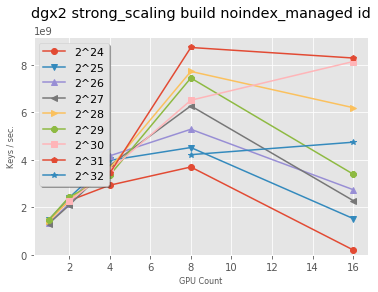

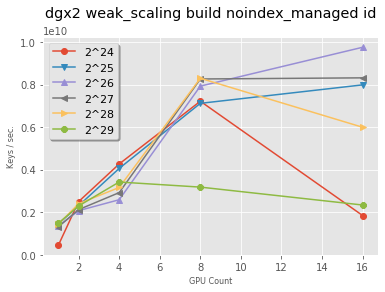

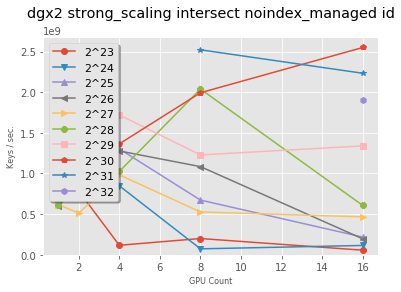

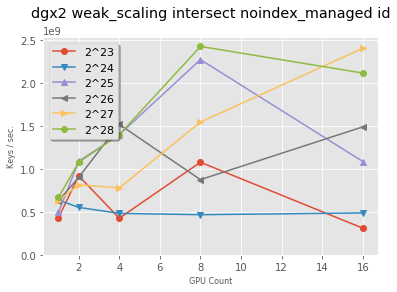

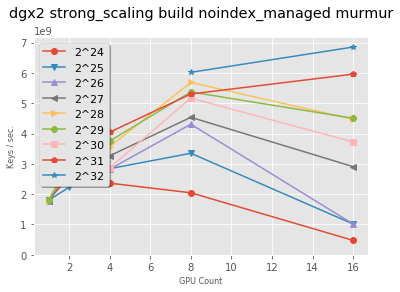

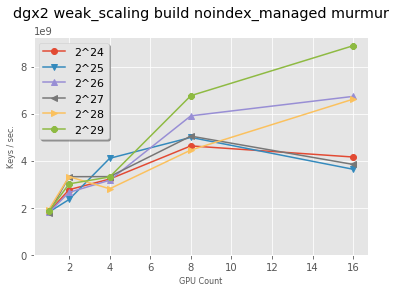

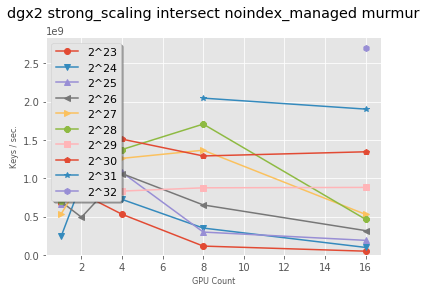

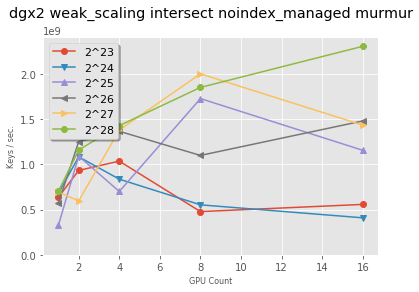

In [207]:
#print("Unmanaged Memory Plots")
#for hash_func in HASH_FUNCS:
#    for exp_type in EXP_TYPES:
#        for exp in EXPERIMENTS:
#            if exp == "duplicate_keys":
#                continue
#            plotThroughput(system, hash_func, exp, exp_type, "noindex_nomanaged")
#        # plotSpeedup(system, exp, exp_type, "index_nomanaged")
#            
system = "dgx2"
print("Managed Memory Plots")
for hash_func in HASH_FUNCS:
    for exp_type in EXP_TYPES:
        for exp in EXPERIMENTS:
            if exp == "duplicate_keys":
                continue
            plotThroughput(system, hash_func, exp, exp_type, "noindex_managed")
        
    # plotSpeedup(system, exp, exp_type, "index_managed")

Managed Memory Plots


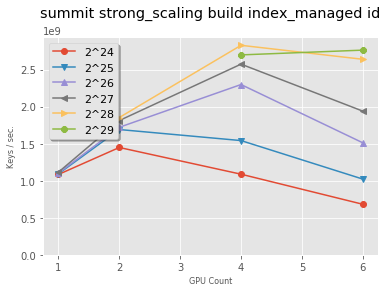

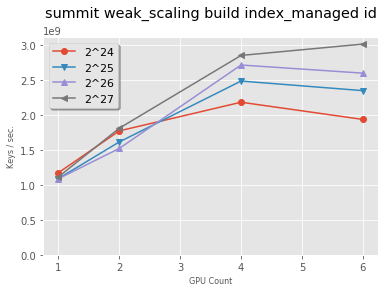

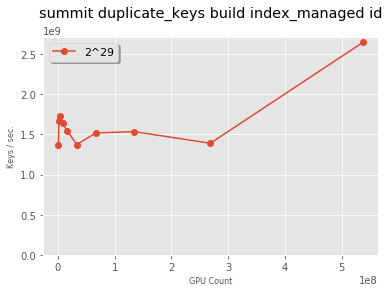

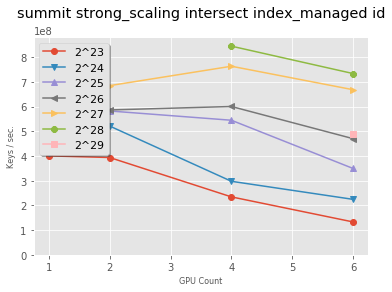

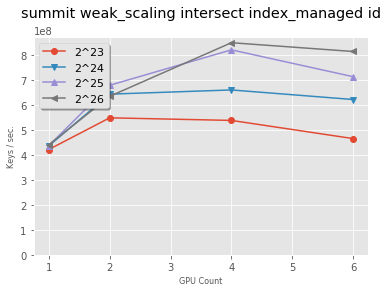

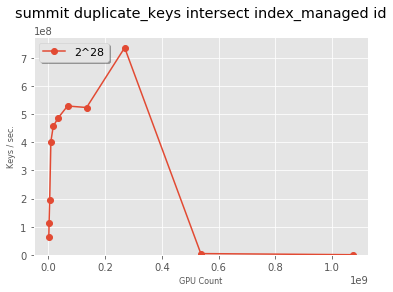

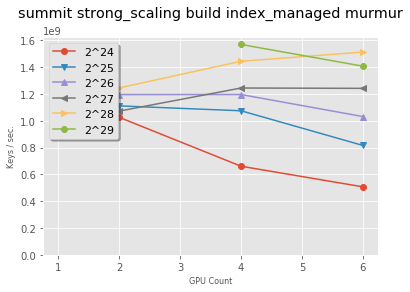

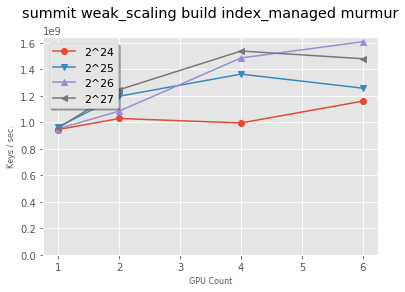

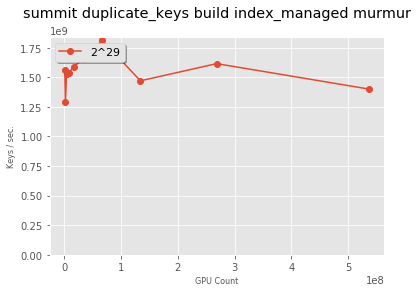

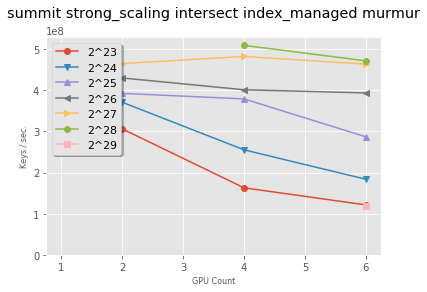

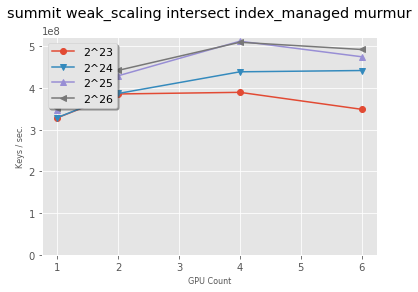

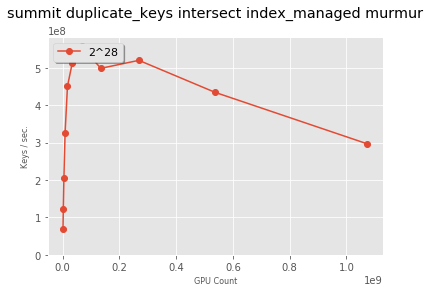

In [74]:
# print("Unmanaged Memory Plots")
# system = "summit"
# for exp_type in EXP_TYPES:
#     if exp_type == "intersect":
#         continue
#     for exp in EXPERIMENTS:
#         if exp == "duplicate_keys":
#             continue
#         plotThroughput(system, exp, exp_type, "noindex_nomanaged")
#     # plotSpeedup(system, exp, exp_type, "index_nomanaged")
#             
print("Managed Memory Plots")
for hash_func in HASH_FUNCS:
    for exp_type in EXP_TYPES:
        for exp in EXPERIMENTS:
            plotThroughput(system, hash_func, exp, exp_type, "index_managed")
    # plotSpeedup(system, exp, exp_type, "index_managed")

In [298]:
def loadStrongScalingProf(system, hash_func):
    exp = "strong_scaling"
    for exp_type in EXP_TYPES:
        if exp_type == "intersect":
            continue
        for mode in MODES:
            file_name = "./" + system + "/" + exp + "/results/" + exp_type + "/" + exp + "_" + mode + "_" + hash_func + ".prof"
            with open(file_name, "r") as data:
                keycount = -1
                gpucount = -1
                for line in data:
                    if exp in line or "keycount" in line or "tests" in line or "total\n" in line:
                        continue
                    
                    if "totaltimes:" in line:
                        line_info = line.strip("\n").split()
                        times = list(map(float, line_info[1].split(",")))
                        for i, comp in enumerate(COMPONENTS["build"]):
                            results_prof[system][hash_func][exp][exp_type][mode][keycount][comp].append((gpucount, times[i]))
                            
                        results_prof[system][hash_func][exp][exp_type][mode][keycount]["phase1"].append((gpucount, times[0]))
                        results_prof[system][hash_func][exp][exp_type][mode][keycount]["phase2"].append((gpucount, times[1] + times[2] + times[3]))
                        results_prof[system][hash_func][exp][exp_type][mode][keycount]["phase3"].append((gpucount, times[4]))
                        results_prof[system][hash_func][exp][exp_type][mode][keycount]["phase4"].append((gpucount, times[5]))
                        results_prof[system][hash_func][exp][exp_type][mode][keycount]["misc"].append((gpucount, times[6] - sum(times[0:6])))
                    else:
                        line_info = line.strip("\n").split(",")

                        keycount = int(line_info[0])
                        gpucount = int(line_info[1])
                        if gpucount == 1:
                            results_prof[system][hash_func][exp][exp_type][mode][keycount] = dict()
                            for comp in COMPONENTS["build"]:
                                results_prof[system][hash_func][exp][exp_type][mode][keycount][comp] = []
                            for group in GROUPS["build"]:
                                results_prof[system][hash_func][exp][exp_type][mode][keycount][group] = []
                
def loadWeakScalingProf(system, hash_func):
    exp = "weak_scaling"
    for exp_type in EXP_TYPES:
        for mode in MODES:
            file_name = "./" + system + "/" + exp + "/results/" + exp_type + "/" + exp + "_" + mode + "_" + hash_func + ".prof"
            with open(file_name, "r") as data:
                keycount = -1
                gpucount = -1
                for line in data:
                    if exp in line or "keycount" in line or "tests" in line or "oom" in line or "total\n" in line:
                        continue
                    
                    if (exp_type == "build" and "totaltimes:" in line) or (exp_type == "intersect" and "times:" in line):
                        line_info = line.strip("\n").split()
                        times = list(map(float, line_info[1].split(",")))
                        key_per_dev = int(keycount / gpucount)
                        for i, comp in enumerate(COMPONENTS["build"]):
                            results_prof[system][hash_func][exp][exp_type][mode][key_per_dev][comp].append((gpucount, times[i]))
                            
                        results_prof[system][hash_func][exp][exp_type][mode][key_per_dev]["phase1"].append((gpucount, times[0]))
                        results_prof[system][hash_func][exp][exp_type][mode][key_per_dev]["phase2"].append((gpucount, times[1] + times[2] + times[3]))
                        results_prof[system][hash_func][exp][exp_type][mode][key_per_dev]["phase3"].append((gpucount, times[4]))
                        results_prof[system][hash_func][exp][exp_type][mode][key_per_dev]["phase4"].append((gpucount, times[5]))
                        
                        total_times = results[system][hash_func][exp][exp_type][mode][key_per_dev]
                        if len(total_times) == 0:
                            continue
                        for i in total_times:
                            if i[0] == gpucount:
                                total_time = i[1]
                        
                        if total_time <= 0:
                            print("total_time: {total_time}")
                        # results_prof[system][hash_func][exp][exp_type][mode][key_per_dev]["misc"].append((gpucount, times[6] - sum(times[0:6])))
                        results_prof[system][hash_func][exp][exp_type][mode][key_per_dev]["misc"].append((gpucount, total_time - sum(times[0:6])))
                    else:
                        line_info = line.strip("\n").split(",")

                        keycount = int(line_info[0])
                        gpucount = int(line_info[1])
                        key_per_dev = int(keycount / gpucount)
                        if gpucount == 1:
                            results_prof[system][hash_func][exp][exp_type][mode][key_per_dev] = dict()
                            for comp in COMPONENTS["build"]:
                                results_prof[system][hash_func][exp][exp_type][mode][key_per_dev][comp] = []
                            for group in GROUPS["build"]:
                                results_prof[system][hash_func][exp][exp_type][mode][key_per_dev][group] = []
                

In [299]:
for system in SYSTEMS:
    for hash_func in HASH_FUNCS:
        loadStrongScalingProf(system, hash_func)
        
for system in SYSTEMS:
    for hash_func in HASH_FUNCS:
        loadWeakScalingProf(system, hash_func)

In [320]:
def plotPerf(exp, exp_type, system):
    fig, axes = plt.subplots(1, len(MODES), sharey=True)
    fig.set_size_inches(15, 5)
    
    # cmap = get_cmap(len(PROC_COUNTS))
    # colors = [['b', 'r', 'w'], ['c', 'y', 'b'], ['k', 'm', 'y']]
    # colors = dict()
    # colors["comp"] = 'm'
    # colors["dbcast"] = 'r'
    # colors["sbcast"] = 'b'
    # colors["reduce"] = 'k'
    colors = dict()
    colors["phase1"] = '#27AE60'
    colors["phase2"] = '#F4D03F'
    colors["phase3"] = '#5DADE2'
    colors["phase4"] = '#808B96'
    colors["misc"] = 'k'
    
    # N = len(PROC_COUNTS_15D)
    margin=.15
    width = (1 - margin) / 5
    
    PROC_COUNTS = dict()
    PROC_COUNTS["summit"] = [1, 2, 4, 6]
    PROC_COUNTS["dgx2"] = [1, 2, 4, 8, 16]
    
    phase1_times_dict = dict()
    phase2_times_dict = dict()
    phase3_times_dict = dict()
    phase4_times_dict = dict()
    misc_times_dict = dict()
    
    # for system in SYSTEMS:
    for mode in MODES:
        for proc in PROC_COUNTS[system]:
            phase1_times_dict[proc] = dict()
            phase2_times_dict[proc] = dict()
            phase3_times_dict[proc] = dict()
            phase4_times_dict[proc] = dict()
            misc_times_dict[proc] = dict()
            
            phase1_times_dict[proc][system] = []
            phase2_times_dict[proc][system] = []
            phase3_times_dict[proc][system] = []
            phase4_times_dict[proc][system] = []
            misc_times_dict[proc][system] = []
            
    # for i, system in enumerate(SYSTEMS):
    for i, mode in enumerate(MODES):
        for j, proc in enumerate(PROC_COUNTS[system]):
            phase1_times = []
            phase2_times = []
            phase3_times = []
            phase4_times = []
            misc_times = []

            for hash_func in HASH_FUNCS:
                if len(results_prof[system][hash_func][exp][exp_type][mode].keys()) == 0:
                    continue
                    
                max_keycount = max(results_prof[system][hash_func][exp][exp_type][mode].keys())
                # total_times = results[system][hash_func][exp][exp_type][mode][max_keycount]
                # if len(total_times) == 0:
                #     continue
                # for i in total_times:
                #     if i[0] == proc:
                #         total_time = i[1]
                        
                # print(f"system: {system} proc: {proc} hash: {hash_func} maxk: {max_keycount} mode: {mode} total_time: {total_time}")
                phase1_times.append(results_prof[system][hash_func][exp][exp_type][mode][max_keycount]["phase1"][j][1])
                phase2_times.append(results_prof[system][hash_func][exp][exp_type][mode][max_keycount]["phase2"][j][1])
                phase3_times.append(results_prof[system][hash_func][exp][exp_type][mode][max_keycount]["phase3"][j][1])
                phase4_times.append(results_prof[system][hash_func][exp][exp_type][mode][max_keycount]["phase4"][j][1])
                misc_times.append(results_prof[system][hash_func][exp][exp_type][mode][max_keycount]["misc"][j][1])
                
                total_time = phase1_times[-1] + phase2_times[-1] + phase3_times[-1] + phase4_times[-1]
                phase1_times[-1] /= total_time
                phase2_times[-1] /= total_time
                phase3_times[-1] /= total_time
                phase4_times[-1] /= total_time
                misc_times[-1] /= total_time

            phase1_times_dict[proc][mode] = phase1_times
            phase2_times_dict[proc][mode] = phase2_times
            phase3_times_dict[proc][mode] = phase3_times
            phase4_times_dict[proc][mode] = phase4_times
            misc_times_dict[proc][mode] = misc_times

    
    # for i, system in enumerate(SYSTEMS):
    for i, mode in enumerate(MODES):
        total_times = []
        
        if len(results_prof[system][hash_func][exp][exp_type][mode].keys()) == 0:
            continue
        max_keycount = max(results_prof[system][hash_func][exp][exp_type][mode].keys())
        gpucount = len(results_prof[system][hash_func][exp][exp_type][mode][max_keycount]["phase1"])
        
        num_cols = len(HASH_FUNCS)
        tick_labels = HASH_FUNCS
        ind_range = np.arange(num_cols)
            
        for ind, proc in enumerate(PROC_COUNTS[system]):
            prev_comp_times = [0] * (num_cols)
            # for k, comp in list(enumerate(["phase1", "phase2", "phase3", "phase4", "misc"])): 
            for k, comp in list(enumerate(["phase1", "phase2", "phase3", "phase4"])): 
                if comp == "phase1":
                    comp_times = phase1_times_dict[proc][mode]
                elif comp == "phase2":
                    comp_times = phase2_times_dict[proc][mode]
                elif comp == "phase3":
                    comp_times = phase3_times_dict[proc][mode]
                elif comp == "phase4":
                    comp_times = phase4_times_dict[proc][mode]
                elif comp == "misc":
                    comp_times = misc_times_dict[proc][mode]

                if proc == 1:
                    if comp == "phase1":
                        label = "Partitioning"
                    elif comp == "phase2":
                        label = "Pre-processing"
                    elif comp == "phase3":
                        label = "All-To-All"
                    elif comp == "phase4":
                        label = "Table Construction"
                    elif comp == "misc":
                        label = "Misc"
                else:
                    label = None
                    
                bar = axes[i].bar(ind_range+i*width + (width * ind), comp_times, width, label=label, bottom=prev_comp_times, edgecolor='k', color=colors[comp])
                prev_comp_times = [prev_comp_times[i] + comp_times[i] for i in range(len(prev_comp_times))]
                
                if comp == "misc" and hash_func == "murmur":
                    print(f"proc: {proc} mode: {mode} prev_comp_times: {prev_comp_times}")
                
                if comp == "phase4":
                    for rectind, rect in enumerate(bar):
                        axes[i].text(rect.get_x() + rect.get_width()/2.0 + 0.005, prev_comp_times[rectind] - 0.15, 'P=%d' % proc, ha='center', va='bottom', rotation=90, fontsize=15)
                            
            
    axes[0].set_ylabel("Fraction of Total Time",fontsize=20, color="black")
    # for i in range(len(SYSTEMS)):
    for i in range(len(MODES)):
        axes[i].set_ylim(ymin=0)
        axes[i].set_ylim(ymax=1.0)
        if MODES[i] == "rand":
            axes[i].set_xlabel("Random Keys",fontsize=20, color="black")    
        elif MODES[i] == "seq":
            axes[i].set_xlabel("Sequential Keys",fontsize=20, color="black")    
        axes[i].set_xticklabels(axes[i].xaxis.get_majorticklabels(), ha="left")
        axes[i].tick_params(axis='x', labelsize=20)
        axes[i].tick_params(axis='y', labelsize=20)
        [j.set_color("black") for j in axes[i].get_xticklabels()]
        [j.set_color("black") for j in axes[i].get_yticklabels()]
        
    title = exp + "_" + exp_type + "_" + system + "_prof"
    # # lgd = plt.legend(loc="upper right", prop={'size':18}, bbox_to_anchor=(1.25, 1.30))
    handles, labels = axes[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc="upper center", prop={'size':18}, ncol=5, mode="expand", bbox_to_anchor=(0.06, 0.90, 0.77, .102))
    # lgd = fig.legend(handles, labels, loc="center right", prop={'size':18}, mode="expand", bbox_to_anchor=(0.85, 0.7, 0.2, .102))

    plt.savefig(title + ".pdf", format="pdf", bbox_extra_artists=(lgd,), bbox_inches='tight');
    # plt.savefig(title + ".pdf", format="pdf", bbox_inches='tight');
    plt.show()

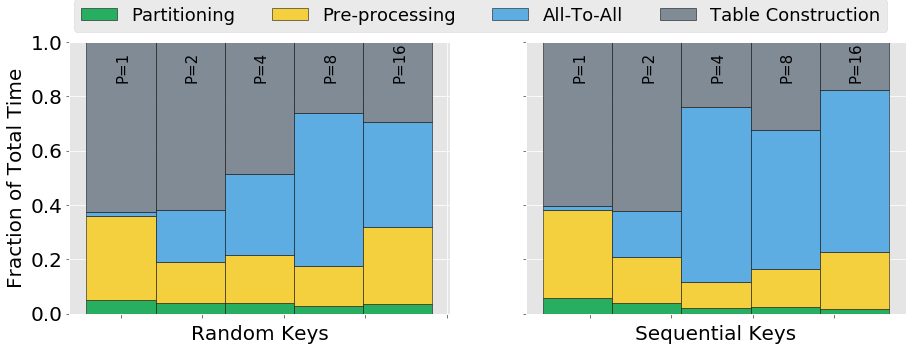

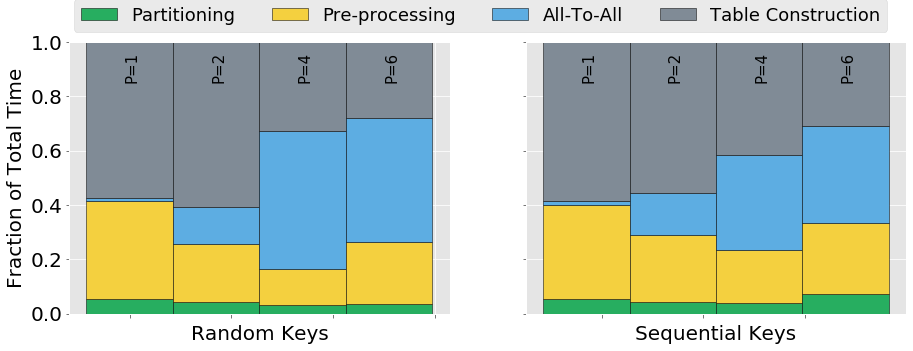

In [321]:
# for mode in MODES:
#     plotPerf("weak_scaling", "build", mode)
for system in SYSTEMS:
    plotPerf("weak_scaling", "build", system)

In [383]:
def plotScalabilityCondensed(exp, system, exp_type):
    # fig, axes = plt.subplots(1, len(SYSTEMS))
    fig, axes = plt.subplots(1, len(MODES), sharey=True)
    fig.set_size_inches(15, 4)
    # fig, axes = plt.subplots(nrows=1,sharex=True)
    # fig.set_size_inches(5,3)

    # plot_data = results[system][hash_func][exp][exp_type][mode]
    
    # cmap = get_cmap(len(plot_data.items()))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # colors = ['#27AE60','#34675C', '#5DADE2', '#808B96']
    
    # for i, system in enumerate(SYSTEMS):
    for i, mode in enumerate(MODES):
        for hash_func in HASH_FUNCS:
            plot_data = results[system][hash_func][exp][exp_type][mode]
            
            # if mode == "noindex_managed":
            if mode == "rand":
                keycounts = list(plot_data.keys())
                
            k_array = [-4, -3, -2, -1]
            if exp == "duplicate_keys":
                k_array = [0]
            # Plot the 3 largest keycounts
            for k in k_array:
                keyc = keycounts[k]
                # print(f"exp: {exp} system: {system} exp_type: {exp_type} mode: {mode} hash_func: {hash_func} keyc: {keyc}")
                data_points = plot_data[keyc]
                x = [i[0] for i in data_points]
                y = [i[1] for i in data_points]

                for j in range(len(y)):
                    if exp == "weak_scaling":
                        y[j] = (keyc * x[j]) / y[j]
                    else:
                        y[j] = keyc / y[j]
                    y[j] = y[j] / (10**9)
                    
                    if exp == "duplicate_keys":
                        x[j] = keyc / x[j]

                label = "2^" + str(int(np.log(keyc) / np.log(2))) + "-" + hash_func
                
                line_type = ""
                if hash_func == "murmur":
                    line_type += "b"
                else:
                    line_type += "r"
                
                if k == -4:
                    line_type += "s-."
                elif k == -3:
                    line_type += "^-"
                elif k == -2:
                    line_type += "P--"
                elif k == -1:
                    line_type += "D:"
                elif k == 0:
                    line_type += "s-"
                    
                axes[i].plot(x, y, line_type, label=label,
                          color=colors[k],
                          linewidth=3,
                          markersize=9)
        
    #axes.plot(threads, threads, label="Ideal",color=plt.rcParams['axes.color_cycle'][4])
    #axes.set_yticks(np.arange(0, 5.0, 0.5))

    # plt.title(system + " " + exp + " " + exp_type + " " + mode + " " + hash_func, pad=20)
    
    axes[0].set_ylabel("Billion Keys\nper Second",fontsize=20, color="black")    
    
    #plt.xticks(fontsize=8)
    #plt.yticks(fontsize=8)
    
    # for i in range(len(SYSTEMS)):
    for i in range(len(MODES)):
        if system == "dgx2":
            axes[i].set_xlim(xmin=1)
            axes[i].set_ylim(ymin=1)
        if MODES[i] == "rand":
            axes[i].set_xlabel("GPU Counts\nRandom Keys",fontsize=20, color="black")    
        elif MODES[i] == "seq":
            axes[i].set_xlabel("GPU Counts\nSequential Keys",fontsize=20, color="black")    
        axes[i].tick_params(axis='x', labelsize=20)
        axes[i].tick_params(axis='y', labelsize=20)
        [j.set_color("black") for j in axes[i].get_xticklabels()]
        [j.set_color("black") for j in axes[i].get_yticklabels()]
            
        if exp == "duplicate_keys":
            axes[i].set_xscale('log', basex=2)
        if system == "dgx2":
            axes[i].set_xscale('log', basex=2)
            axes[i].set_yscale('log', basey=2)
            
        if system == "dgx2" and exp is not "duplicate_keys":
            axes[i].set_xticks([1, 2, 4, 8, 16])

    
    
    handles, labels = axes[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc="upper center", prop={'size':15}, ncol=4, mode="expand", bbox_to_anchor=(0.06, 1.10, 0.77, .102))
    # plt.legend(loc='upper left', ncol=1, fancybox=True, shadow=True, fontsize=11)
    title = system + "_" + exp + "_" + exp_type 
    # plt.savefig(title + ".pdf", format="pdf", bbox_inches='tight');
    # plt.show()

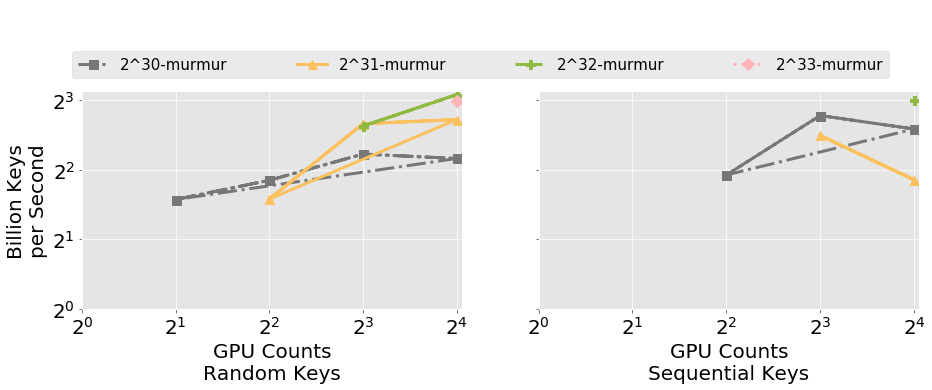

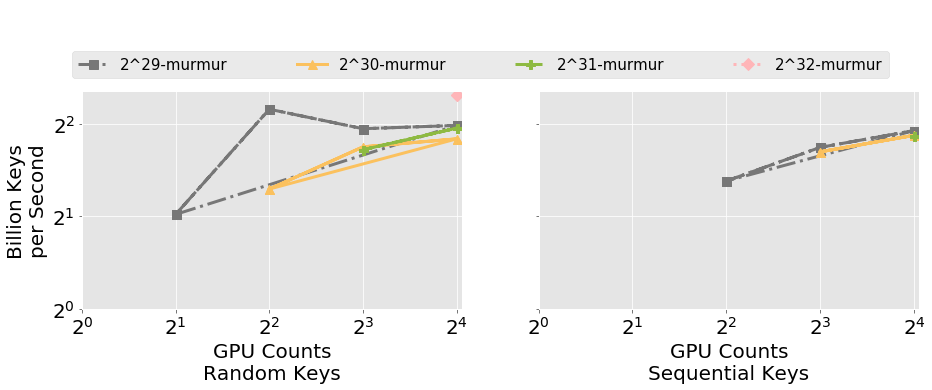

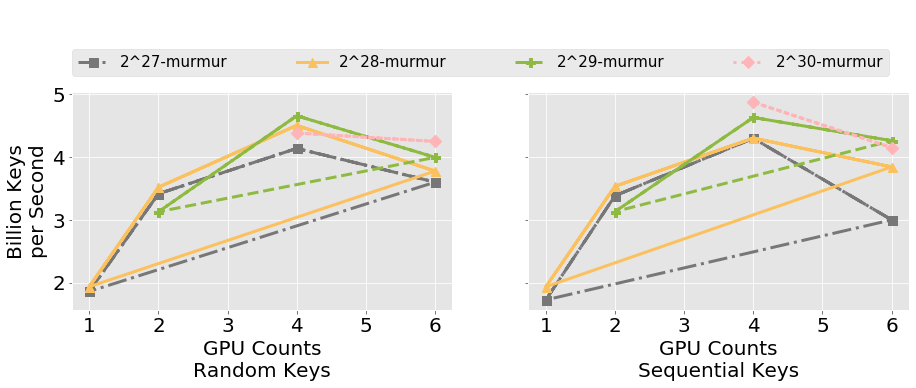

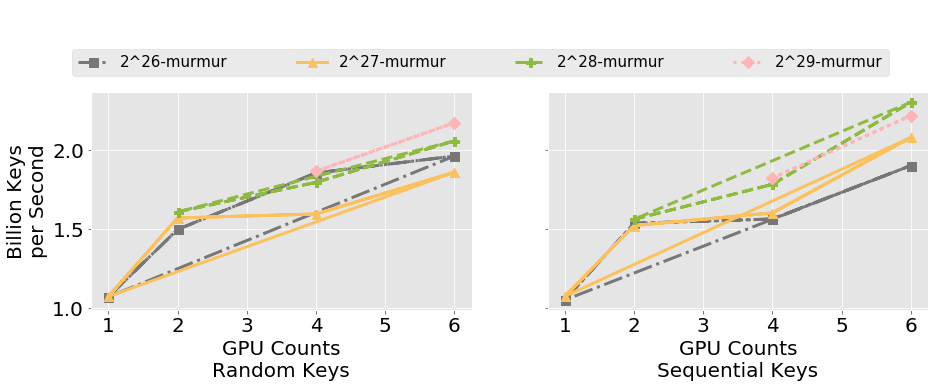

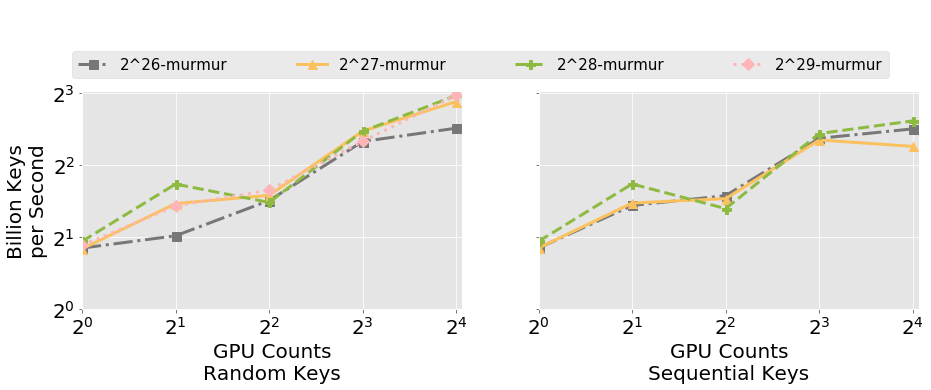

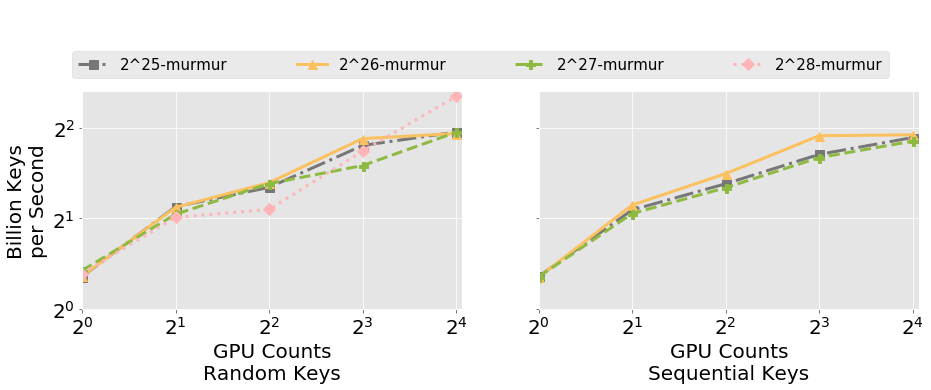

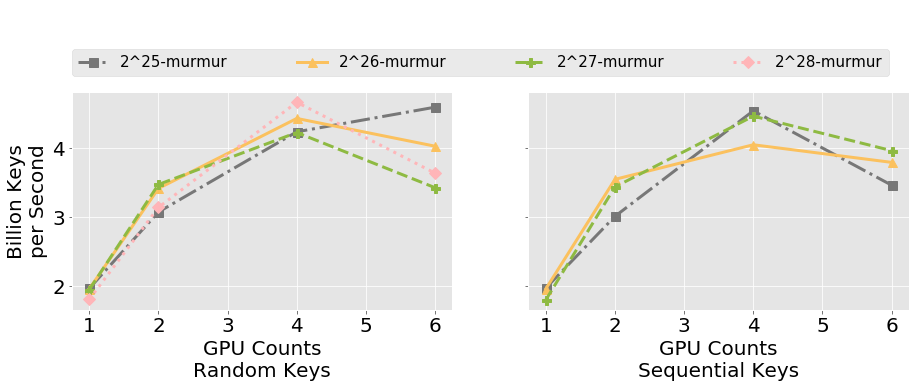

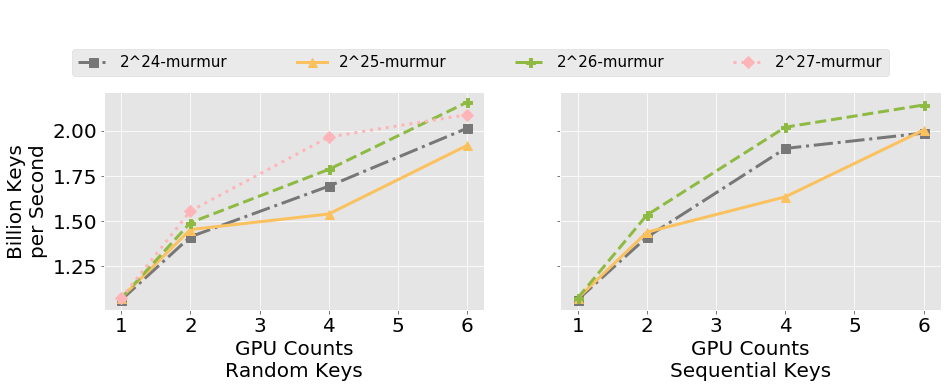

In [384]:
# plotScalabilityCondensed("strong_scaling", "summit", "build")
for exp in EXPERIMENTS:
    # if exp == "strong_scaling" or exp == "weak_scaling":
    if exp == "duplicate_keys":
        continue
    for system in SYSTEMS:
        for exp_type in EXP_TYPES:
            plotScalabilityCondensed(exp, system, exp_type)

In [372]:
def plotScalabilityCondensedDK(exp, system):
    # fig, axes = plt.subplots(1, len(SYSTEMS))
    fig, axes = plt.subplots(1, len(EXP_TYPES), sharey=True)
    fig.set_size_inches(15, 4)
    # fig, axes = plt.subplots(nrows=1,sharex=True)
    # fig.set_size_inches(5,3)

    # plot_data = results[system][hash_func][exp][exp_type][mode]
    
    # cmap = get_cmap(len(plot_data.items()))
    # colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = ['#27AE60','#1995AD', '#5DADE2', '#808B96']
    
    # for i, system in enumerate(SYSTEMS):
    for i, exp_type in enumerate(EXP_TYPES):
        for hash_func in HASH_FUNCS:
            for m, mode in enumerate(MODES):
                plot_data = results[system][hash_func][exp][exp_type][mode]

                # if mode == "noindex_managed":
                if mode == "rand":
                    keycounts = list(plot_data.keys())

                keyc = keycounts[0]
                # print(f"exp: {exp} system: {system} exp_type: {exp_type} mode: {mode} hash_func: {hash_func} keyc: {keyc}")
                data_points = plot_data[keyc]
                x = [i[0] for i in data_points]
                y = [i[1] for i in data_points]

                for j in range(len(y)):
                    y[j] = keyc / y[j]
                    y[j] = y[j] / (10**9)
                    x[j] = keyc / x[j]

                label = "2^" + str(int(np.log(keyc) / np.log(2))) + "-" + hash_func + "-" + mode

                line_type = ""
                if hash_func == "murmur":
                    line_type += "b"
                else:
                    line_type += "r"

                if mode == "rand":
                    line_type += "s-"
                elif mode == "seq":
                    line_type += "D--"

                axes[i].plot(x, y, line_type, label=label,
                          color=colors[m],
                          linewidth=3,
                          markersize=9)
        
    #axes.plot(threads, threads, label="Ideal",color=plt.rcParams['axes.color_cycle'][4])
    #axes.set_yticks(np.arange(0, 5.0, 0.5))

    # plt.title(system + " " + exp + " " + exp_type + " " + mode + " " + hash_func, pad=20)
    
    axes[0].set_ylabel("Billion Keys\nper Second",fontsize=20, color="black")    
    #plt.xticks(fontsize=8)
    #plt.yticks(fontsize=8)
    
    # for i in range(len(SYSTEMS)):
    for i in range(len(EXP_TYPES)):
        if system != "dgx2":
            axes[i].set_ylim(ymin=0)
        if EXP_TYPES[i] == "build":
            axes[i].set_xlabel("Average Key Occurrences",fontsize=20, color="black")    
        elif EXP_TYPES[i] == "intersect":
            axes[i].set_xlabel("Average Key Occurrences",fontsize=20, color="black")    
        axes[i].tick_params(axis='x', labelsize=20)
        axes[i].tick_params(axis='y', labelsize=20)
        [j.set_color("black") for j in axes[i].get_xticklabels()]
        [j.set_color("black") for j in axes[i].get_yticklabels()]
            
        axes[i].set_xscale('log', basex=2)
        axes[i].set_xscale('log', basex=2)
    
    
    handles, labels = axes[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc="upper center", prop={'size':15}, ncol=4, mode="expand", bbox_to_anchor=(0.06, 1.00, 0.77, .102))
    # plt.legend(loc='upper left', ncol=1, fancybox=True, shadow=True, fontsize=11)
    title = system + "_" + exp
    plt.savefig(title + ".pdf", format="pdf", bbox_inches='tight');
    # plt.show()

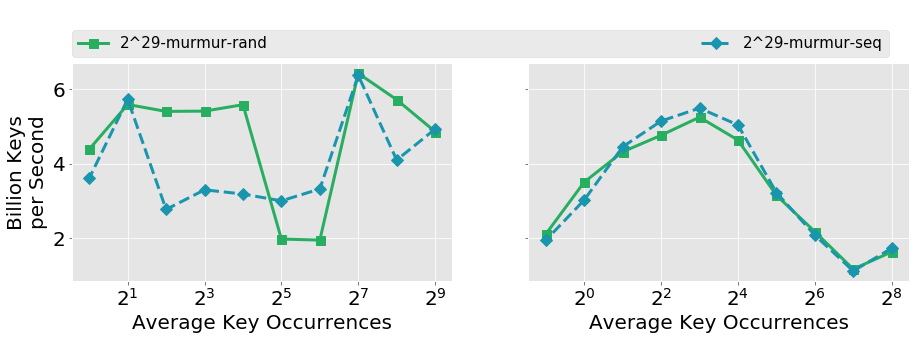

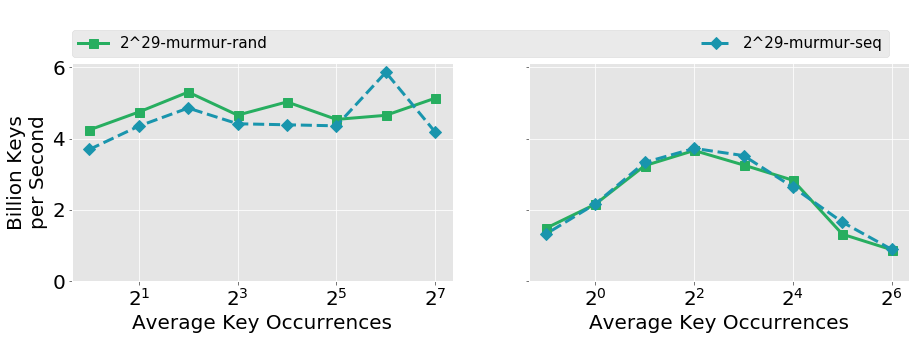

In [373]:
for system in SYSTEMS:
    plotScalabilityCondensedDK("duplicate_keys", system)